# AutoVI Dataset Exploration

This notebook explores the AutoVI visual inspection dataset for federated learning experiments.

## Contents
1. Dataset Loading
2. Image Dimensions Analysis
3. Class Distribution
4. Defect Type Analysis
5. FL Partitioning Preview

In [1]:
import sys
sys.path.insert(0, '..')

import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from src.data import (
    AutoVIDataset,
    CATEGORIES,
    SMALL_OBJECTS,
    LARGE_OBJECTS,
)
from src.data.partitioner import (
    IIDPartitioner,
    CategoryPartitioner,
    compute_partition_stats,
)

In [2]:
# Configuration
project_root = Path('..').resolve()
DATA_ROOT = project_root / "dataset"
print(f"Dataset root: {DATA_ROOT}")
print(f"Categories: {CATEGORIES}")
print(f"Small objects (400x400): {SMALL_OBJECTS}")
print(f"Large objects (1000x750): {LARGE_OBJECTS}")

Dataset root: /home/miriam/Documents/autovi_evaluation_code/dataset
Categories: ['engine_wiring', 'pipe_clip', 'pipe_staple', 'tank_screw', 'underbody_pipes', 'underbody_screw']
Small objects (400x400): ['engine_wiring', 'pipe_clip', 'pipe_staple']
Large objects (1000x750): ['tank_screw', 'underbody_pipes', 'underbody_screw']


## 1. Dataset Loading

In [3]:
# Load train and test datasets
train_dataset = AutoVIDataset(root_dir=DATA_ROOT, split='train')
test_dataset = AutoVIDataset(root_dir=DATA_ROOT, split='test')

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 1523
Test samples: 2399


In [4]:
# Get statistics
train_stats = train_dataset.get_statistics()
test_stats = test_dataset.get_statistics()

print("\nTrain Statistics:")
print(json.dumps(train_stats, indent=2))

print("\nTest Statistics:")
print(json.dumps(test_stats, indent=2))


Train Statistics:
{
  "total": 1523,
  "by_category": {
    "engine_wiring": {
      "good": 285,
      "defective": 0
    },
    "pipe_clip": {
      "good": 195,
      "defective": 0
    },
    "pipe_staple": {
      "good": 191,
      "defective": 0
    },
    "tank_screw": {
      "good": 318,
      "defective": 0
    },
    "underbody_pipes": {
      "good": 161,
      "defective": 0
    },
    "underbody_screw": {
      "good": 373,
      "defective": 0
    }
  },
  "by_defect_type": {},
  "by_label": {
    "0": 1523,
    "1": 0
  }
}

Test Statistics:
{
  "total": 2399,
  "by_category": {
    "engine_wiring": {
      "good": 285,
      "defective": 322
    },
    "pipe_clip": {
      "good": 195,
      "defective": 142
    },
    "pipe_staple": {
      "good": 188,
      "defective": 117
    },
    "tank_screw": {
      "good": 318,
      "defective": 95
    },
    "underbody_pipes": {
      "good": 161,
      "defective": 184
    },
    "underbody_screw": {
      "good": 374,


## 2. Image Dimensions Analysis

In [5]:
# Sample images to check dimensions
dimensions = {}
for category in CATEGORIES:
    cat_dataset = AutoVIDataset(root_dir=DATA_ROOT, categories=[category], split='train')
    if len(cat_dataset) > 0:
        sample = cat_dataset[0]
        img = sample['image']
        dimensions[category] = img.size
        print(f"{category}: {img.size} (WxH)")

engine_wiring: (400, 400) (WxH)
pipe_clip: (400, 400) (WxH)
pipe_staple: (400, 400) (WxH)
tank_screw: (1000, 750) (WxH)
underbody_pipes: (1000, 750) (WxH)
underbody_screw: (1000, 750) (WxH)


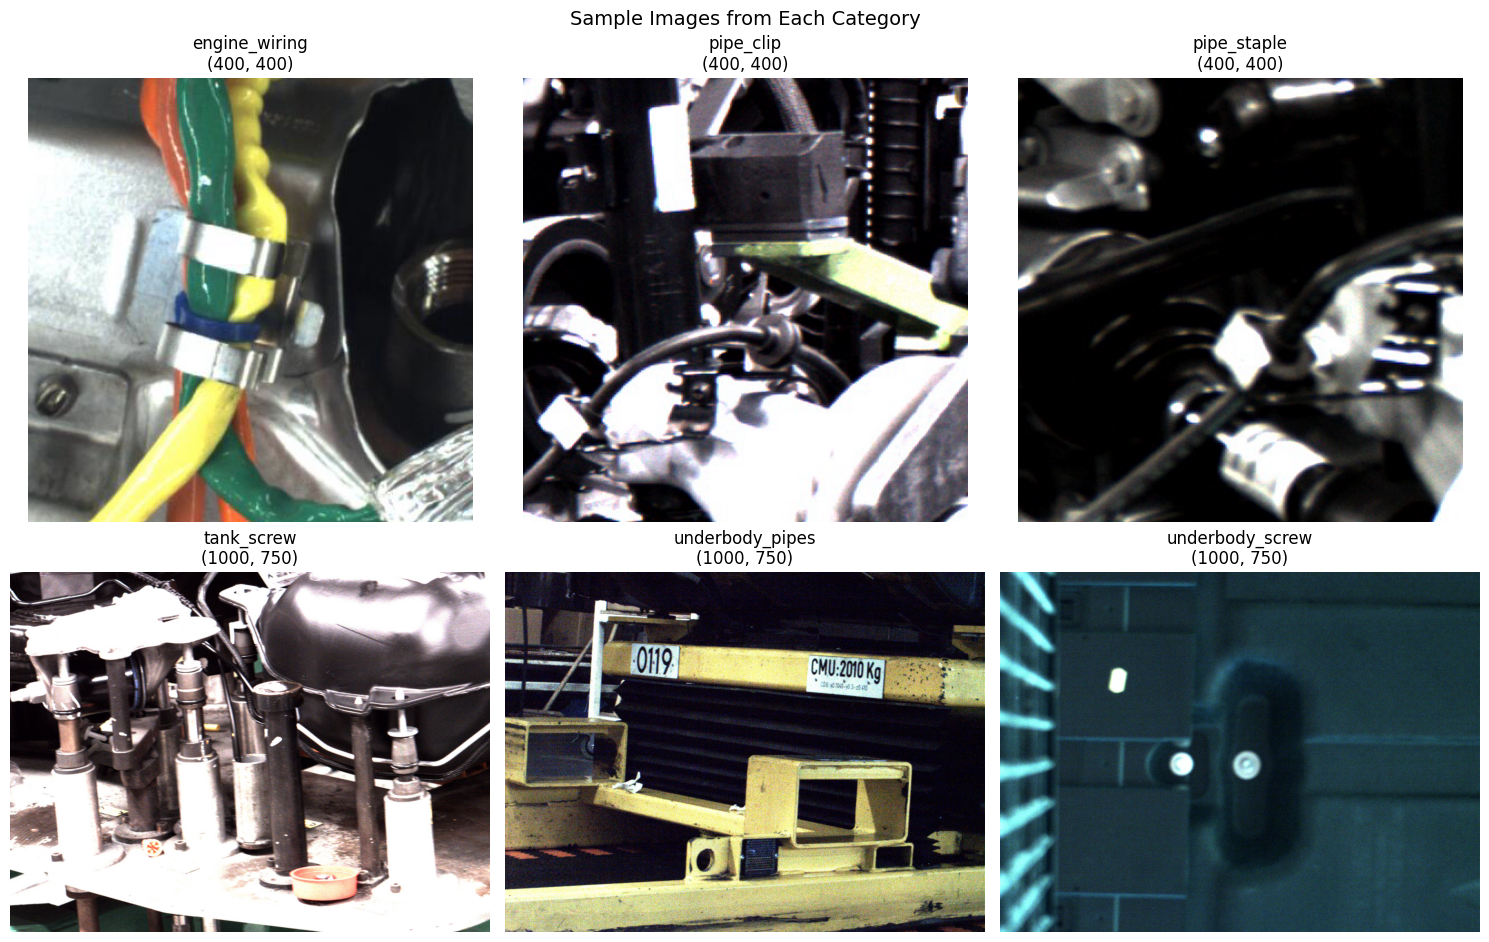

In [6]:
# Display sample images from each category
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, category in enumerate(CATEGORIES):
    cat_dataset = AutoVIDataset(root_dir=DATA_ROOT, categories=[category], split='train')
    if len(cat_dataset) > 0:
        sample = cat_dataset[0]
        axes[idx].imshow(sample['image'])
        axes[idx].set_title(f"{category}\n{sample['image'].size}")
        axes[idx].axis('off')

plt.suptitle('Sample Images from Each Category', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Class Distribution

In [7]:
# Create distribution summary table
print("\n" + "="*80)
print(f"{'Category':<20} {'Train':>10} {'Test Good':>12} {'Test Defect':>12} {'Total':>10}")
print("="*80)

total_train = 0
total_test_good = 0
total_test_defect = 0

for category in CATEGORIES:
    train_count = train_stats['by_category'].get(category, {}).get('good', 0)
    test_good = test_stats['by_category'].get(category, {}).get('good', 0)
    test_defect = test_stats['by_category'].get(category, {}).get('defective', 0)
    total = train_count + test_good + test_defect
    
    total_train += train_count
    total_test_good += test_good
    total_test_defect += test_defect
    
    print(f"{category:<20} {train_count:>10} {test_good:>12} {test_defect:>12} {total:>10}")

print("="*80)
grand_total = total_train + total_test_good + total_test_defect
print(f"{'TOTAL':<20} {total_train:>10} {total_test_good:>12} {total_test_defect:>12} {grand_total:>10}")


Category                  Train    Test Good  Test Defect      Total
engine_wiring               285          285          322        892
pipe_clip                   195          195          142        532
pipe_staple                 191          188          117        496
tank_screw                  318          318           95        731
underbody_pipes             161          161          184        506
underbody_screw             373          374           18        765
TOTAL                      1523         1521          878       3922


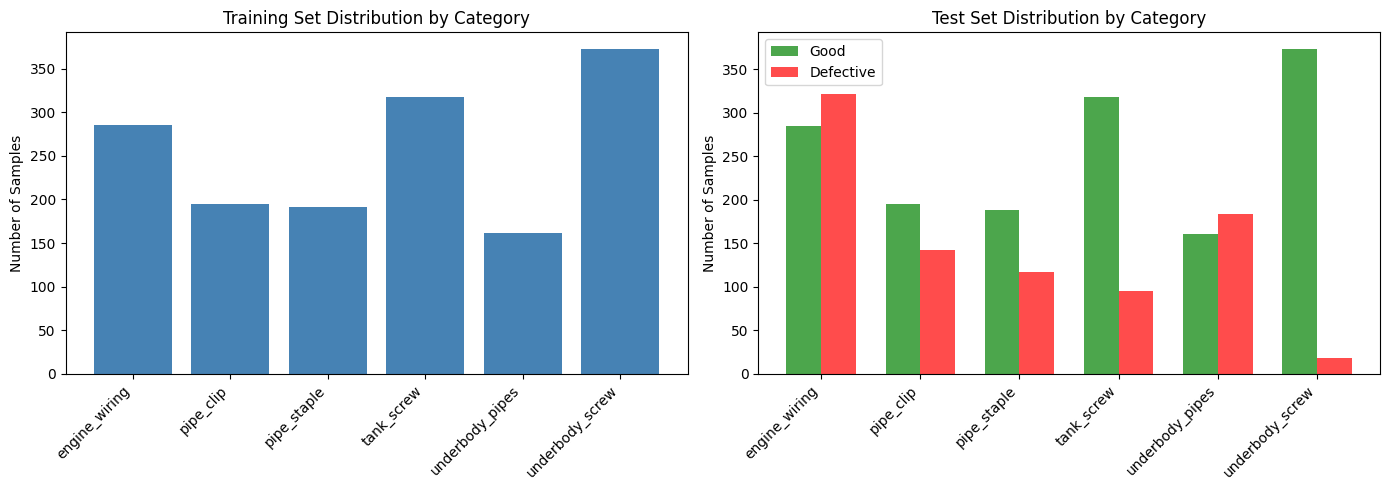

In [8]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution by category
categories = list(train_stats['by_category'].keys())
train_counts = [train_stats['by_category'][cat]['good'] for cat in categories]

ax1.bar(range(len(categories)), train_counts, color='steelblue')
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Training Set Distribution by Category')

# Test distribution (good vs defective)
test_good_counts = [test_stats['by_category'][cat]['good'] for cat in categories]
test_defect_counts = [test_stats['by_category'][cat]['defective'] for cat in categories]

x = np.arange(len(categories))
width = 0.35

ax2.bar(x - width/2, test_good_counts, width, label='Good', color='green', alpha=0.7)
ax2.bar(x + width/2, test_defect_counts, width, label='Defective', color='red', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(categories, rotation=45, ha='right')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Test Set Distribution by Category')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Defect Type Analysis

In [9]:
# Analyze defect types
print("\nDefect Types by Category:")
print("="*60)

for category in CATEGORIES:
    cat_dataset = AutoVIDataset(root_dir=DATA_ROOT, categories=[category], split='test')
    defects = [s[3] for s in cat_dataset.samples if s[3] is not None]
    defect_counts = Counter(defects)
    
    print(f"\n{category}:")
    if defect_counts:
        for defect, count in defect_counts.most_common():
            print(f"  - {defect}: {count}")
    else:
        print("  No defects found")


Defect Types by Category:

engine_wiring:
  - fastening: 277
  - multiple: 33
  - cardboard: 5
  - blue_hoop: 5
  - obstruction: 2

pipe_clip:
  - unclipped: 141
  - operator: 1

pipe_staple:
  - missing: 117

tank_screw:
  - missing: 95

underbody_pipes:
  - obstruction: 180
  - operator: 3
  - multiple: 1

underbody_screw:
  - missing: 18


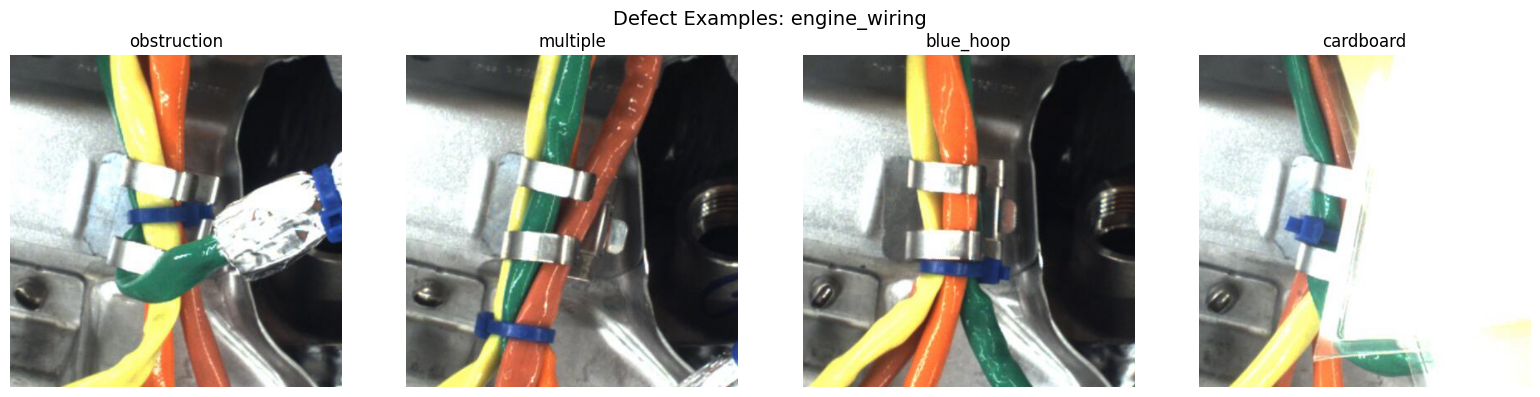

In [10]:
# Display defect examples for engine_wiring
category = 'engine_wiring'
cat_dataset = AutoVIDataset(root_dir=DATA_ROOT, categories=[category], split='test')

# Get unique defect types
defect_types = list(set(s[3] for s in cat_dataset.samples if s[3] is not None))

if defect_types:
    fig, axes = plt.subplots(1, min(len(defect_types), 4), figsize=(16, 4))
    if len(defect_types) == 1:
        axes = [axes]
    
    for idx, defect_type in enumerate(defect_types[:4]):
        defect_indices = cat_dataset.get_defect_indices(defect_type)
        if defect_indices:
            sample = cat_dataset[defect_indices[0]]
            axes[idx].imshow(sample['image'])
            axes[idx].set_title(f"{defect_type}")
            axes[idx].axis('off')
    
    plt.suptitle(f'Defect Examples: {category}', fontsize=14)
    plt.tight_layout()
    plt.show()

## 5. FL Partitioning Preview

In [11]:
# IID Partitioning
iid_partitioner = IIDPartitioner(num_clients=5, seed=42)
iid_partition = iid_partitioner.partition(train_dataset)
iid_stats = compute_partition_stats(train_dataset, iid_partition)

print("IID Partition Statistics:")
print("="*60)
for client_id, client_data in iid_stats['clients'].items():
    print(f"\nClient {client_id}: {client_data['num_samples']} samples")
    for cat, count in client_data['by_category'].items():
        print(f"  {cat}: {count}")

IID Partition Statistics:

Client 0: 305 samples
  pipe_staple: 40
  underbody_pipes: 35
  underbody_screw: 74
  pipe_clip: 40
  tank_screw: 64
  engine_wiring: 52

Client 1: 305 samples
  underbody_screw: 83
  engine_wiring: 46
  underbody_pipes: 27
  tank_screw: 54
  pipe_clip: 51
  pipe_staple: 44

Client 2: 305 samples
  pipe_staple: 30
  engine_wiring: 71
  underbody_screw: 67
  underbody_pipes: 31
  tank_screw: 72
  pipe_clip: 34

Client 3: 304 samples
  pipe_staple: 40
  underbody_screw: 63
  pipe_clip: 37
  engine_wiring: 62
  tank_screw: 68
  underbody_pipes: 34

Client 4: 304 samples
  pipe_staple: 37
  underbody_screw: 86
  underbody_pipes: 34
  tank_screw: 60
  engine_wiring: 54
  pipe_clip: 33


In [12]:
# Category-based (Non-IID) Partitioning
category_partitioner = CategoryPartitioner(seed=42)
category_partition = category_partitioner.partition(train_dataset)
category_stats = compute_partition_stats(train_dataset, category_partition)

print("Category-based (Non-IID) Partition Statistics:")
print("="*60)

client_roles = {
    0: "Engine Assembly",
    1: "Underbody Line",
    2: "Fastener Station",
    3: "Clip Inspection",
    4: "Quality Control",
}

for client_id, client_data in category_stats['clients'].items():
    role = client_roles.get(int(client_id), "Unknown")
    print(f"\nClient {client_id} ({role}): {client_data['num_samples']} samples")
    for cat, count in client_data['by_category'].items():
        print(f"  {cat}: {count}")

Category-based (Non-IID) Partition Statistics:

Client 0 (Engine Assembly): 257 samples
  engine_wiring: 257

Client 1 (Underbody Line): 481 samples
  underbody_pipes: 145
  underbody_screw: 336

Client 2 (Fastener Station): 459 samples
  tank_screw: 287
  pipe_staple: 172

Client 3 (Clip Inspection): 176 samples
  pipe_clip: 176

Client 4 (Quality Control): 150 samples
  engine_wiring: 28
  pipe_clip: 19
  pipe_staple: 19
  tank_screw: 31
  underbody_pipes: 16
  underbody_screw: 37


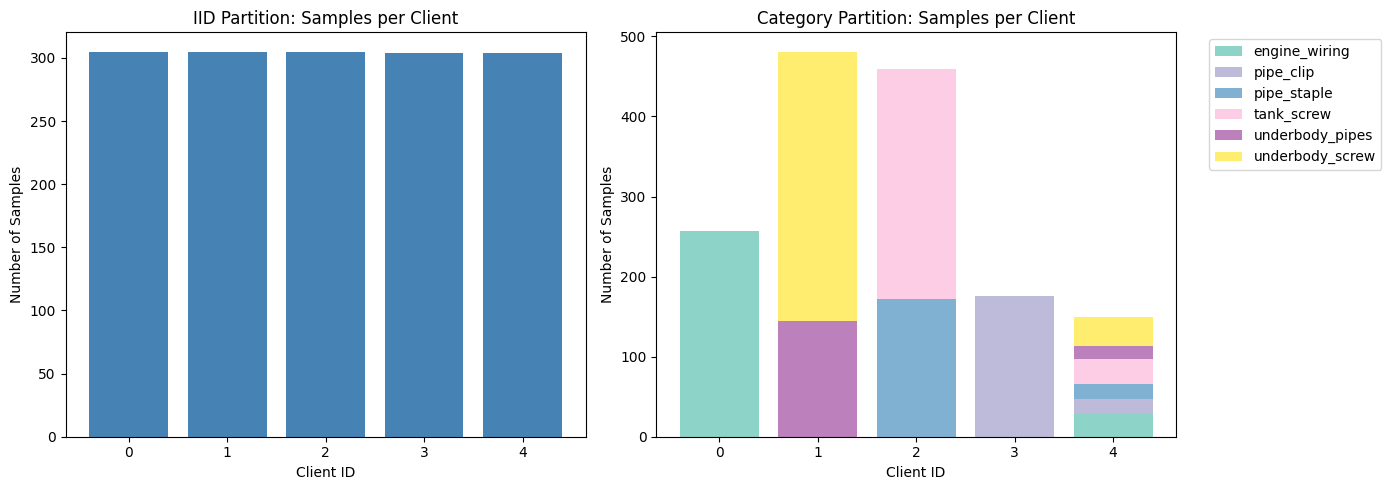

In [13]:
# Visualize partition distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# IID partition
client_ids = list(iid_stats['clients'].keys())
iid_counts = [iid_stats['clients'][c]['num_samples'] for c in client_ids]

ax1.bar(client_ids, iid_counts, color='steelblue')
ax1.set_xlabel('Client ID')
ax1.set_ylabel('Number of Samples')
ax1.set_title('IID Partition: Samples per Client')

# Category partition with stacked bars
client_ids = list(category_stats['clients'].keys())
bottom = np.zeros(len(client_ids))

colors = plt.cm.Set3(np.linspace(0, 1, len(CATEGORIES)))

for idx, cat in enumerate(CATEGORIES):
    counts = [category_stats['clients'][c]['by_category'].get(cat, 0) for c in client_ids]
    ax2.bar(client_ids, counts, bottom=bottom, label=cat, color=colors[idx])
    bottom += np.array(counts)

ax2.set_xlabel('Client ID')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Category Partition: Samples per Client')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Summary

Key findings from the AutoVI dataset exploration:

1. **Dataset Size**: Total of ~1,500 training samples and ~2,400 test samples
2. **Categories**: 6 object types with varying defect types
3. **Image Sizes**: Small objects (400x400) and large objects (1000x750)
4. **Class Imbalance**: Some categories have more samples than others
5. **FL Partitioning**: Both IID and category-based strategies implemented